In [30]:
import numpy as np
from io import StringIO
import os
import matplotlib.pyplot as plt
import joblib

In [31]:
#The model was trained using these r-values in [1/GeV]. You need to define your dipole on this r-grid:
r_values = [
    1.010000000e-06,1.212000000e-06,1.454400000e-06,1.745280000e-06,2.094336000e-06,2.513203200e-06,
    3.015843840e-06,3.619012608e-06,4.342815130e-06,5.211378156e-06,6.253653787e-06,7.504384544e-06,
    9.005261453e-06,1.080631374e-05,1.296757649e-05,1.556109179e-05,1.867331015e-05,2.240797218e-05,
    2.688956661e-05,3.226747994e-05,3.872097592e-05,4.646517111e-05,5.575820533e-05,6.690984640e-05,
    8.029181568e-05,9.635017881e-05,1.156202146e-04,1.387442575e-04,1.664931090e-04,1.997917308e-04,
    2.397500769e-04,2.877000923e-04,3.452401108e-04,4.142881329e-04,4.971457595e-04,5.965749114e-04,
    7.158898937e-04,8.590678725e-04,1.030881447e-03,1.237057736e-03,1.484469284e-03,1.781363140e-03,
    2.137635768e-03,2.565162922e-03,3.078195507e-03,3.693834608e-03,4.432601529e-03,5.319121835e-03,
    6.382946202e-03,7.659535443e-03,9.191442532e-03,1.102973104e-02,1.323567725e-02,1.588281269e-02,
    1.905937523e-02,2.287125028e-02,2.744550034e-02,3.293460040e-02,3.952152048e-02,4.742582458e-02,
    5.691098950e-02,6.829318740e-02,8.195182488e-02,9.834218985e-02,1.000000000e-01,1.100000000e-01,
    1.210000000e-01,1.331000000e-01,1.464100000e-01,1.610510000e-01,1.771561000e-01,1.948717100e-01,
    2.143588810e-01,2.357947691e-01,2.593742460e-01,2.853116706e-01,3.138428377e-01,3.452271214e-01,
    3.797498336e-01,4.177248169e-01,4.594972986e-01,5.054470285e-01,5.559917313e-01,6.115909045e-01,
    6.727499949e-01,7.400249944e-01,8.140274939e-01,8.954302433e-01,9.849732676e-01,1.083470594e+00,
    1.191817654e+00,1.310999419e+00,1.442099361e+00,1.586309297e+00,1.744940227e+00,1.919434250e+00,
    2.111377675e+00,2.322515442e+00,2.554766986e+00,2.810243685e+00,3.091268053e+00,3.400394859e+00,
    3.740434344e+00,4.114477779e+00,4.525925557e+00,4.978518112e+00,5.476369924e+00,6.024006916e+00,
    6.626407608e+00,7.289048369e+00,8.017953205e+00,8.819748526e+00,9.701723378e+00,1.000000000e+01,
    1.400000000e+01,1.960000000e+01,2.744000000e+01,3.841600000e+01,5.378240000e+01,7.529536000e+01
]

r = np.array(r_values)

#Function to load the trained model
def load_models():
    try:
        # Load scaler and model from file
        filename_scaler = 'scaler-xList-log.joblib'
        filename_pca = 'pca_model-xList-log.joblib'
        filename_models = 'rcBK-RF-xList-log.joblib'

        Scalers = joblib.load(filename_scaler)
        PCA_models = joblib.load(filename_pca)
        RF_models = joblib.load(filename_models)
        
        return Scalers, PCA_models, RF_models
    except Exception as e:
        print(f"Error loading models: {e}")
        return None
    
#Function to interpolate in the target x value
def interpolator(x):
    #array of x values
    exponent_values = np.linspace(-6, -2, 9)
    x_values = 10.**(exponent_values)  
    x_values_arr = np.array(x_values)
    
    insert_index = np.searchsorted(x_values_arr, x)
    adjacent_values = x_values_arr[max(0, insert_index - 1):insert_index + 1]

    imp = [insert_index - 1, insert_index]
    frac = (adjacent_values[1]-x)/(adjacent_values[1]-adjacent_values[0])
    
    return imp, frac

#Function that will predict the x-evolved function given the input function, target x value, and C^2 parameter
# x was trained between 1e-2 and 1e-6. Recommended C^2 range: 1 to 100 (training includes 0.01 to 1000) 
def predict(input_function, x, C2):

    input_function = np.log(input_function+1e-12)
    
    new_input_function = np.append(input_function, C2)
    
    imp, frac = interpolator(x)
    
    # Standardize the data
    scaler = Scalers[imp[0]]
    X_val_standardized_0 = scaler.transform([new_input_function])
    scaler = Scalers[imp[1]]
    X_val_standardized_1 = scaler.transform([new_input_function])

    # Apply PCA to reduce dimensionality
    pca = PCA_models[imp[0]]
    X_val_pca_0 = pca.transform(X_val_standardized_0)
    pca = PCA_models[imp[1]]
    X_val_pca_1 = pca.transform(X_val_standardized_1)
    
    #Predict on the fly:
    predicted_output_values = [RF_models[imp[0]].predict(X_val_pca_0)[0], RF_models[imp[1]].predict(X_val_pca_1)[0]]

    output_values = np.exp((1.-frac)*predicted_output_values[1] + (frac)*predicted_output_values[0]) - 1e-12

    return output_values

In [32]:
#Load model
result = load_models()
if result is not None:
    Scalers, PCA_models, RF_models = result
    print("Model loaded.")
    # Continue with further processing
else:
    print("Failed to load models. Check the error message above for details.")

Model loaded.


In [33]:
#Define IPSat
Nc=3.
alphas=0.1

def xg(x):
    return 2.308*x**(-0.058)*(1.-x)**5.6

def Tp(b,Bp):
    return 1./2./Bp*np.exp(-b**2./2./Bp)

def F(x,r,b,Bp):
    return np.pi**2./2./Nc*(r**2.)*alphas*xg(x)*Tp(b,Bp)

def dipole(x, r, b, Bp):
    return (1.-np.exp(-F(x,r,b,Bp)))

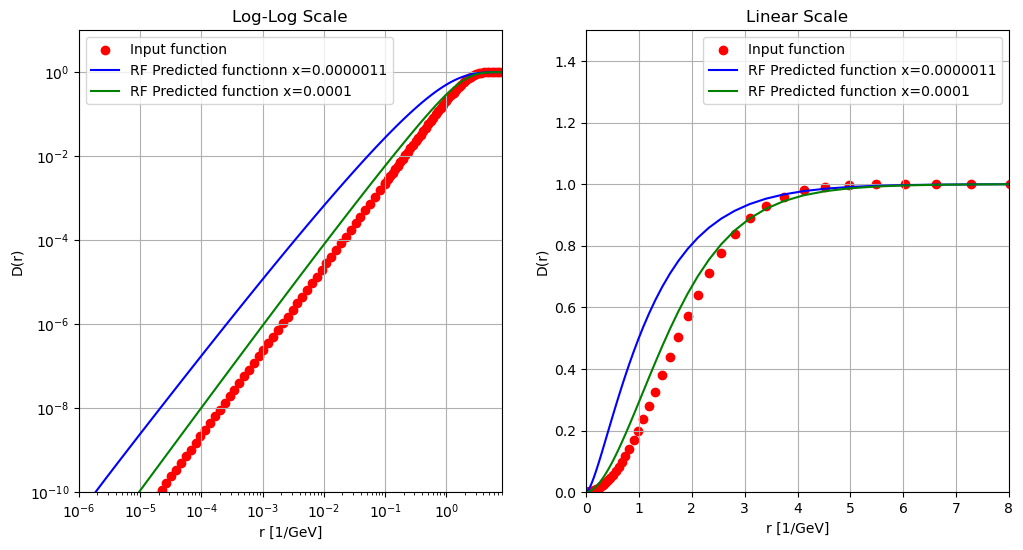

In [35]:
#Example using an input from IPSat:
IPSat_input = dipole(0.01, r, 0.2, 1.)
output_values = predict(IPSat_input, 0.0000011, 10.)
output_values_2 = predict(IPSat_input, 0.001, 10.)

# Plot with log-log scale
plt.figure(figsize=(12, 6))

# Plot with log-log scale
plt.subplot(1, 2, 1)
plt.xlim(0.000001, 8.) 
plt.ylim(1e-10, 10.) 
plt.scatter(r, IPSat_input, color='red', label='Input function')
plt.plot(r, output_values, color='blue', label='RF Predicted functionn x=0.0000011')
plt.plot(r, output_values_2, color='green', label='RF Predicted function x=0.0001')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Log-Log Scale')
plt.legend()
plt.grid(True)

# Plot with linear scale
plt.subplot(1, 2, 2)
plt.xlim(0, 8.) 
plt.ylim(0, 1.5) 
plt.scatter(r, IPSat_input, color='red', label='Input function')
plt.plot(r, output_values, color='blue', label='RF Predicted function x=0.0000011')
plt.plot(r, output_values_2, color='green', label='RF Predicted function x=0.0001')
plt.xlabel('r [1/GeV]')
plt.ylabel('D(r)')
plt.title('Linear Scale')
plt.legend()
plt.grid(True)

In [37]:
def SaveEvolvedAmplitude(input, filename, C2, x0, xvals):
    '''Save dipole amplitude to a datafile at all different x values
    The format is the same as the output of the rcbk code

    x0: Bjorken-x at the initial condition
    C2: C^2 in the running coupling
    '''
    
    # x values: need to start from the initial condition
    xvals = np.sort(xvals)[::-1]
    if np.abs(np.log(xvals[0]/x0)) > 0.00001:
        print("Largest x value should correspond to the initial condition")
        return

    # check that r_grid has logarithmic spacing
    ratios = [r[i+1]/r[i] for i in range(len(r)-1)]
    if not np.allclose(ratios, [r[1]/r[0]]*(len(r)-1)):
        print("r grid is not logarithmic, can not generate a datafile!")
  
    
    with open(filename,"w") as file:
        file.write("###" + str(r_values[0]) + "\n")
        file.write("###"+str(r_values[1]/r_values[0])+"\n") # step
        file.write("###"+str(len(r_values))+"\n")
        file.write("###"+str(x0)+"\n")

        for x in xvals:
            y = np.log(x0/x)
            file.write("###"+str(y)+"\n")
            dipoles = predict(input, x, C2)
            for d in dipoles:
                file.write(str(d)+"\n")
    file.close()



SaveEvolvedAmplitude(input=IPSat_input,filename="datafile",C2=10,x0=0.01,xvals=np.geomspace(1.001e-6,0.01,6))